# Notebook to match VASCA sources to SIMBAD database sources positionally
Set your option in the cell bellow

In [1]:
from astropy import units as uu
region_name = "ALL_10-800" #"CAINGSGII_10-800" #"TDS" #"CAINGSGII_10-800" #"WD" #"MDIS_10-800" #"TDS" #  _ELAISN1
region_cat_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+"_cat.fits"

In [2]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from vasca.region import Region
import vasca.visualization as vvis
from vasca.utils import otype2ogroup,dd_ogrp2otypes, dd_ogrp2col, get_col_cycler,add_ogrp

# Get region
rc = Region()
rc.load_from_fits(region_cat_fname)

### Prepare association data for plotting

In [3]:
#Add Object group to source table
rc.copy_table_columns("tt_sources","tt_simbad",["otype","ogrp","match_distance"],"rg_src_id")
rc.tt_sources.rename_column("match_distance","match_distance_simbad")
rc.tt_sources.rename_column("ogrp","ogrp_simbad")
sel_simbad = rc.tt_sources["sel"].data
print(f"Number of SIMBAD matches is: {sel_simbad.sum()}  ({100* sel_simbad.sum() / len(rc.tt_sources)} )%")

rc.copy_table_columns("tt_sources","tt_gaiadr3",["PQSO", "PGal", "PSS","match_distance","Gmag_abs","BP-RP", "ogrp"],"rg_src_id")
rc.tt_sources.rename_column("match_distance","match_distance_gaiadr3")
rc.tt_sources.rename_column("ogrp","ogrp_gaiadr3")
sel_gaiadr3 = rc.tt_sources["sel"].data
print(f"Number of GAIA matches is: {sel_gaiadr3.sum()}  ({100*sel_gaiadr3.sum() / len(rc.tt_sources)} )%")

sel_match = np.array(sel_simbad+sel_gaiadr3, dtype=bool)
print(f"Total number of matches is: {sel_match.sum()}  ({100*sel_match.sum() / len(rc.tt_sources)} )%")

display(rc.tt_sources)
#display(rc.tt_simbad)


Number of SIMBAD matches is: 4318  (60.67163130532528 )%
Number of GAIA matches is: 5687  (79.90726429675425 )%
Total number of matches is: 6202  (87.14345932274836 )%


fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,coadd_src_id,coadd_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,coadd_ffactor,coadd_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs,hr,hr_err,simbad_match_id,gaiadr3_match_id,otype,ogrp_simbad,match_distance_simbad,PQSO,PGal,PSS,match_distance_gaiadr3,Gmag_abs,BP-RP,ogrp_gaiadr3
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,,,,,,,,arcsec,,,,arcsec,,,
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],int64,int32,int32,float32,float32,int32,int32,bytes32,bytes8,float32,float32,float32,float32,float32,float32,float32,bytes8
-1,175 .. 98,150.19491746654782,2.067917488917891,0.041145824,-0.33278635,0.15272313,1.0,0.30049813,867,0.063385345,1 .. 2,True,14.334563 .. 8.805813,0.07181169 .. 0.109138064,0.010237182 .. 0.009757584,3.5745542 .. 2.283225,0.0 .. 3.814655e-12,3.7095704 .. 2.3172796,0.97875947 .. 1.0259458,-3.2490458 .. 1.6797316,-1,26,10,0.6041421,0.008988117,0,0,Sy1,AGN,0.7002527,0.001869,0.000724,0.996765,0.7002527,-100.0,0.953236,none
-1,148 .. 130,150.1799556325474,2.1103312162731735,0.041883517,-0.28210574,0.24747498,1.0,0.4775786,67,0.04405546,1 .. 2,True,17.591288 .. 6.566322,0.091125205 .. 0.082030274,0.002693037 .. 0.0027621754,2.8632436 .. 1.2160017,1.9439212e-11 .. 0.48239988,1.9737328 .. 1.0003253,0.98499906 .. 1.0091033,-2.4839041 .. 0.59337366,-1,31,10,0.36145002,0.0069398326,1,1,QSO,AGN,0.91459554,0.000287,0.00016,0.998952,0.91459554,-100.0,1.062943,none
-1,187 .. 68,150.14575415476628,2.043070325208979,0.045412708,-0.37028584,0.20188043,1.0,0.359057,906,0.05303263,1 .. 2,True,10.106851 .. 3.813408,0.06261327 .. 0.08893104,0.026032418 .. 0.0071979486,3.7612705 .. 0.6972077,0.0 .. 0.06236148,5.602206 .. 1.2777138,0.9619016 .. 1.0913291,-4.680506 .. 3.0474873,-1,47,10,0.35370108,0.010773277,3,2,QSO,AGN,0.597173,0.001265,1.3e-05,0.997987,0.597173,-100.0,1.103838,none
-1,223 .. 56,150.10187076794713,2.105622112305161,0.043903112,-0.14818236,0.44276938,0.9999879,0.6311722,167,0.39357263,1 .. 2,True,9.242619 .. 3.2214422,0.05453549 .. 0.08941889,0.0057370258 .. -0.007204072,1.4249276 .. 0.44153178,2.5193283e-11 .. 0.9649644,1.7552807 .. 0.68344927,0.9801208 .. 1.0516087,-2.546556 .. 1.5815244,-1,65,10,0.35043922,0.011155928,4,3,QSO,AGN,0.7378542,1.0,0.0,0.0,0.72707134,-100.0,0.379698,AGN
-1,17 .. 19,150.25768134959162,2.429976464041846,0.1531103,-0.251353,0.67691404,0.00042565385,1.2249864,801,0.44043687,1 .. 2,False,3.6412191 .. 3.0093424,0.15282841 .. 0.1460866,2.0983272 .. -0.03354601,28.29587 .. 0.13118833,0.0 .. 0.9986987,18.125904 .. 0.28323573,1.0971218 .. 1.3153098,2.012671 .. 4.707052,-1,134,9,1.2379429,0.33605915,5,-1,G,GAL,0.66343427,-1.0,-1.0,-1.0,-1.0,-100.0,-1.0,none
-1,162 .. 63,215.0652986717028,52.62191634479354,0.04258191,-0.15678811,0.2601927,0.97151285,0.61557895,493,0.108201735,1 .. 2,True,23.9785 .. 10.414039,0.0822385 .. 0.13372463,0.017198535 .. 0.0045054667,11.087525 .. 1.7450621,0.0 .. 0.0063142804,9.222982 .. 1.5036017,0.98297095 .. 0.9983051,-4.0039735 .. -0.113926,-1,177,8,0.4045591,0.0070522213,6,4,QSO,AGN,0.244159,1.0,0.0,0.0,0.23957047,-100.0,0.654627,AGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-1,6 .. -1,6.013936547211533,-72.22173607880508,0.32587492,-0.31301472,0.3354815,0.3951696,0.56316364,3424414,0.13161364,1 .. 0,True,4.7824826 .. -1.0,0.34806773 .. -1.0,-0.020964481 .. -100.0,0.3542065 .. -1.0,0.77017957 .. -1.0,0.50837004 .. -1.0,2.3786764 .. 1.0,7.450393 .. 0.0,-1,983122,1,-1.0,-1.0,-1,5707,none,none,-1.0,0.0,0.0,0.999957,0.38339496,5.983607,0.779264,Star*


### Create matching table

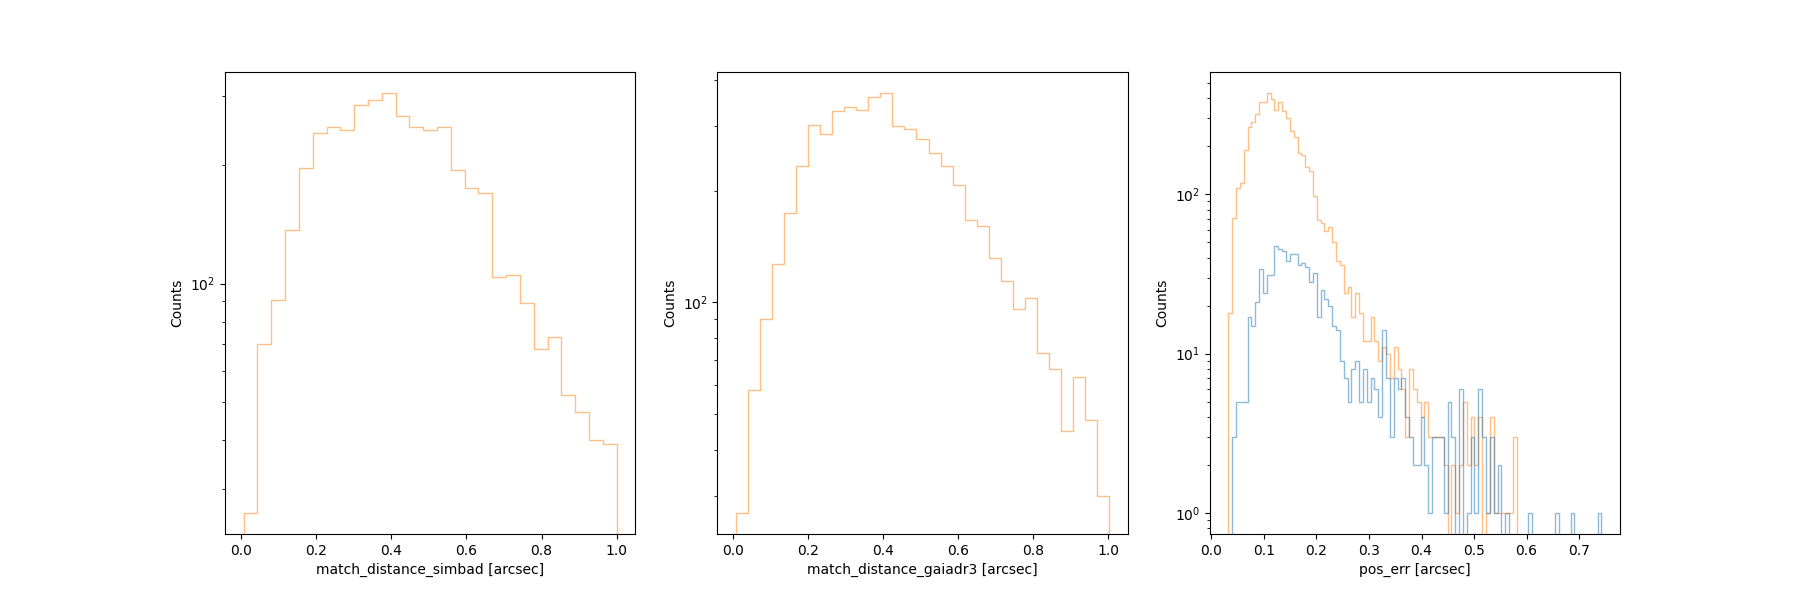

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs = np.array(axs).flatten()
rc.tt_sources["sel"]=sel_simbad
_ = vvis.plot_table_hist(rc.tt_sources[sel_simbad], "match_distance_simbad", ax=axs[0], logx=False, obs_filter_id=None, density= False)
rc.tt_sources["sel"]=sel_gaiadr3
_ = vvis.plot_table_hist(rc.tt_sources[sel_gaiadr3], "match_distance_gaiadr3", ax=axs[1], logx=False, obs_filter_id=None, density= False)
rc.tt_sources["sel"]=sel_match
_ = vvis.plot_table_hist(rc.tt_sources, 'pos_err', ax=axs[2], logx=False, obs_filter_id=None, density= False)

### Plot found object types

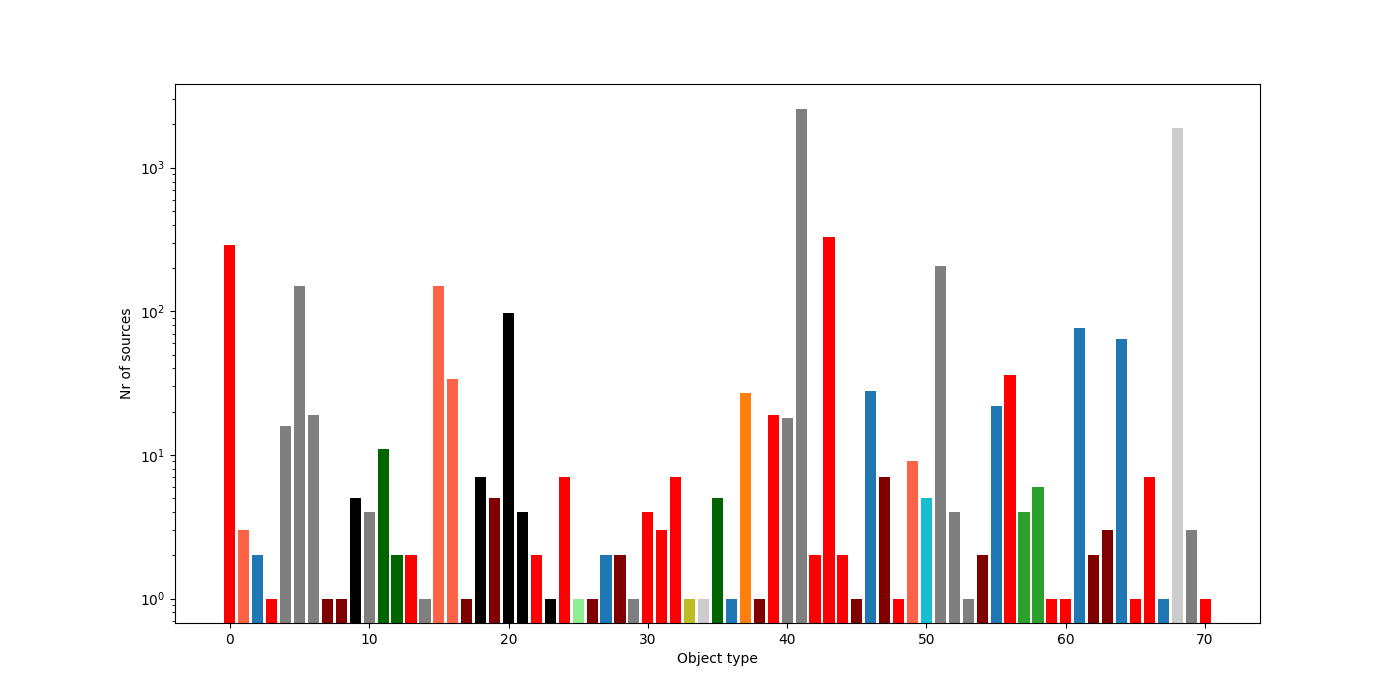

otype Candidate               Description                ogrp     Label                        Category                                          Subcategory                         
----- --------- --------------------------------------- ----- -------------- ------------------------------------------- ------------------------------------------------------------
    ?        --                Object of Unknown Nature   UNK        Unknown 8. BLENDS, ERRORS, NOT WELL DEFINED OBJECTS                                                           --
    *        --                                    Star Star*           Star                        1. TAXONOMY OF STARS                                                           --
   **       **?                 Double or Multiple Star    B*             **                        1. TAXONOMY OF STARS  Interacting Binaries and close Common Proper Motion Systems
  AB*       AB?            Asymptotic Giant Branch Star Star*           AGB*              

In [5]:
sel_mt = rc.tt_sources["sel"]
fig_otypes = plt.figure("Source types",figsize=(14, 7))
fig_otypes.clf()

otypes_all, otype_cts_all= np.unique(rc.tt_sources[sel_mt]["otype"],return_counts=True)
dd_otype2id = dict(zip(list(otypes_all),range(len(otypes_all))))

tt_mt_grp =  rc.tt_sources[sel_mt].group_by("ogrp_simbad")
for group, tt_grp in zip(tt_mt_grp.groups.keys, tt_mt_grp.groups):
    otypes, otype_cts= np.unique(tt_grp["otype"],return_counts=True)
    otypes_id = []
    for otype in otypes:
        otypes_id.append(dd_otype2id[otype])
    plt.bar( otypes_id, otype_cts, align='center', label=group[0], color = dd_ogrp2col[group[0]])
plt.yscale('log')
#plt.grid()
plt.xlabel("Object type")
plt.ylabel("Nr of sources")
plt.show()
plt.legend()
plt.xticks(range(len(otypes_all)), otypes_all, size='small')

rc.tt_otypes["otype","Candidate","Description","ogrp","Label","Category","Subcategory"].pprint_all()#show_dtype=True #,"Status","Priority"


### Scatter plots of source variables by group

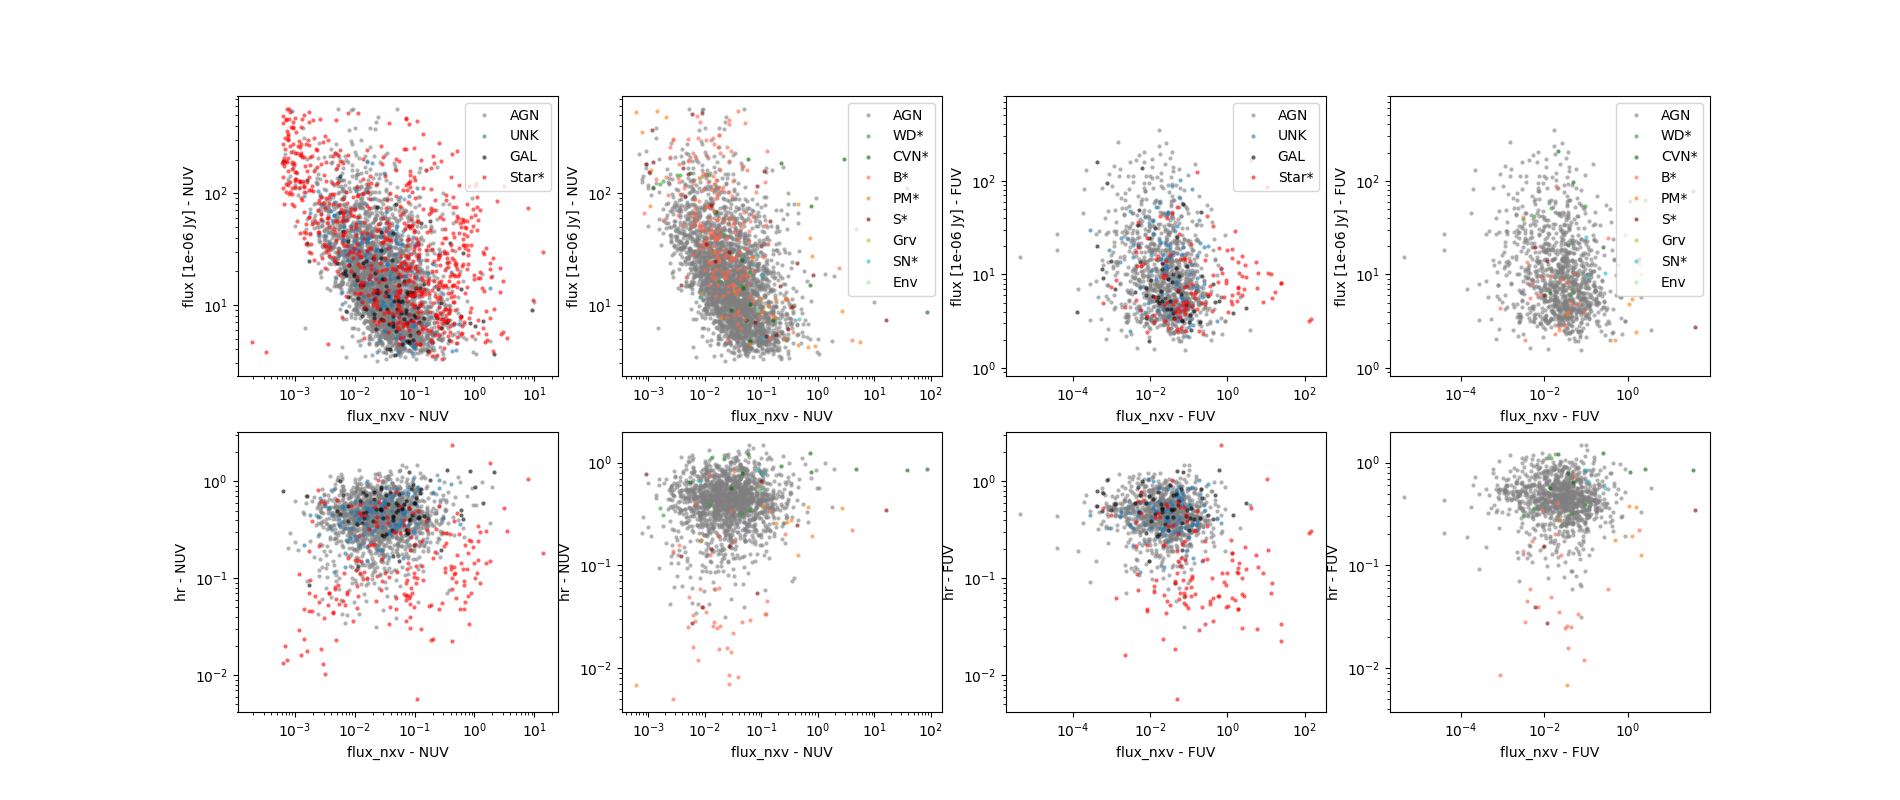

In [6]:
plot_kwargs = {"markersize": 3.0,"alpha":0.6}
fig, axs = plt.subplots(2, 4, figsize=(19, 8))
#fig.clf()
axs = axs.flatten()
plt_ogrops = [["AGN","UNK","GAL",'Star*'],["AGN",'WD*', 'CVN*', 'B*', 'PM*',"S*", 'Grv', 'SN*',"Env"]]

plt_flts = [1,2]
ctr = 0
for flt in plt_flts:
    for ogrps in plt_ogrops:
        axs[ctr].set_prop_cycle(get_col_cycler(ogrps))
        vvis.plot_table_scatter(rc.tt_sources,"flux_nxv", "flux", ax=axs[ctr], xscale="log",yscale="log", obs_filter_id=flt, grp_var="ogrp_simbad",grp_vals = ogrps,**plot_kwargs)

        axs[ctr+4].set_prop_cycle(get_col_cycler(ogrps))
        vvis.plot_table_scatter(rc.tt_sources,"flux_nxv", "hr", ax=axs[ctr+4], xscale="log",yscale="log", obs_filter_id=flt, grp_var="ogrp_simbad",grp_vals = ogrps,**plot_kwargs)
        ctr +=1

_ = axs[0].legend()
_ = axs[1].legend()
_ = axs[2].legend()
_ = axs[3].legend()
#print(dd_ogrp2otypes.keys())r

### Compare object classification from SIMBAD to the one from GAIA-DR3

/home/buehler/mambaforge/envs/vas/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


SIMBAD assoc: orange:AGN; red:Star; brown:Galaxy


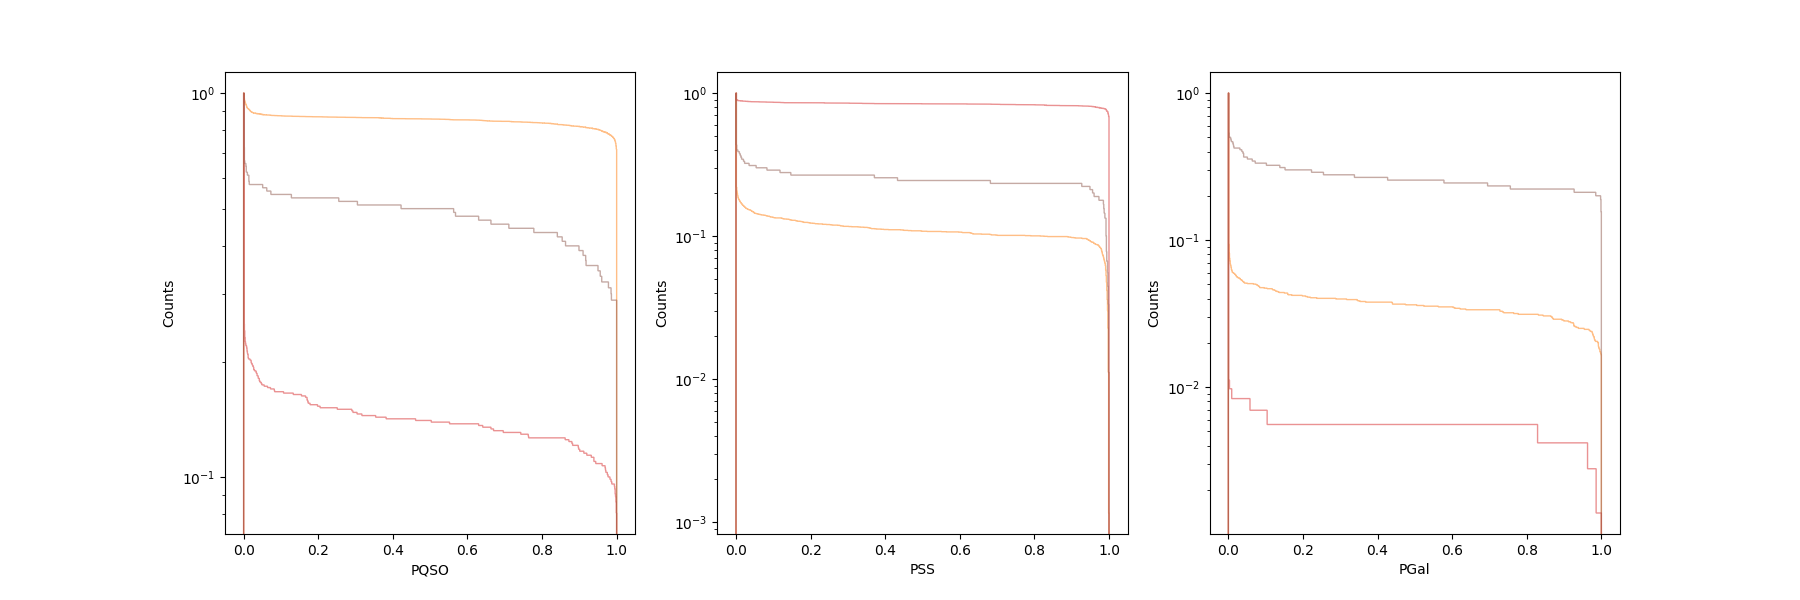

In [7]:
#Reset source selection
rc.tt_sources["sel"]=True

#Define selections for different SIMBAD object groups
sel_AGN = rc.tt_sources["ogrp_simbad"]=="AGN"
sel_star = np.array((rc.tt_sources["ogrp_simbad"]=="Star*")+(rc.tt_sources["ogrp_simbad"]=="S*"), dtype=bool)
sel_gal = rc.tt_sources["ogrp_simbad"]=="GAL"
sels_ogrp = [sel_AGN,sel_star,sel_gal]

#GAIA variables to plot
gaia_vars = ["PQSO","PSS","PGal"]

#Define figure parameters and loop to do plots
fig, axs = plt.subplots(1, 3, figsize=(18, 6),num="Cummulative probabilities of object groups")
hist_bins = np.linspace(0.0,1.0,1001)
hist_dens = True
axs = np.array(axs).flatten()
panel = 0
cumulative = -1
for var in gaia_vars:
    for sel in sels_ogrp:
        _ = vvis.plot_table_hist(rc.tt_sources[sel], var, ax=axs[panel], density= hist_dens, bins=hist_bins,cumulative= cumulative )
    panel+=1
    
#Print out figure labels
print("SIMBAD assoc: orange:AGN; red:Star; brown:Galaxy")

### Hertzsprung russel diagram

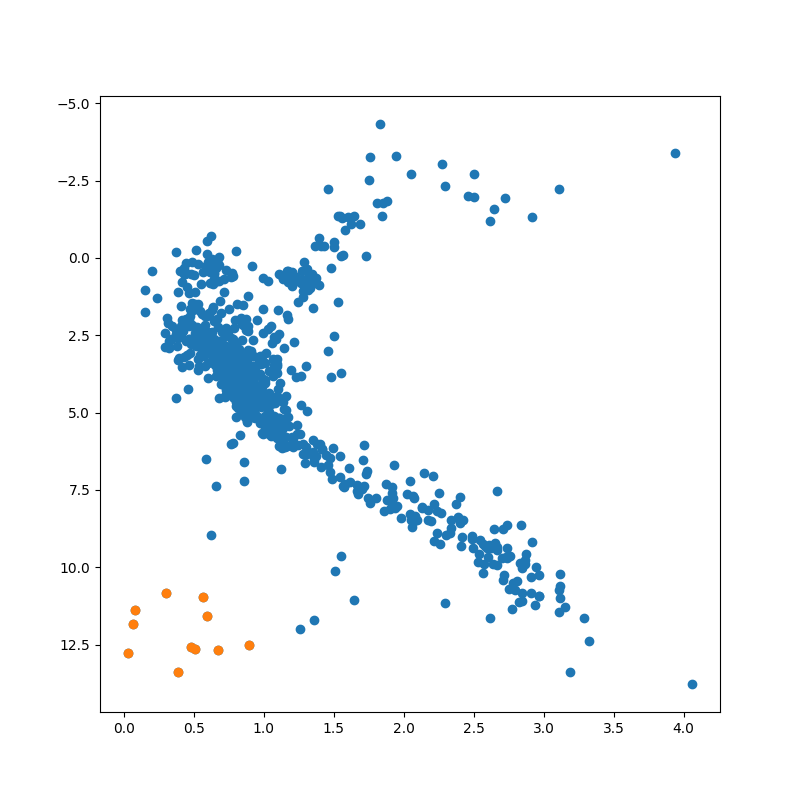

In [8]:
tt_HR = rc.tt_sources[rc.tt_sources["Gmag_abs"]>-10]
fig, axs = plt.subplots(1, 1, figsize=(8, 8),num="HR")
axs = np.array(axs).flatten()
axs[0].plot(tt_HR["BP-RP"],tt_HR["Gmag_abs"],"o")
axs[0].plot(tt_HR["BP-RP"][tt_HR["ogrp_gaiadr3"]=="WD*"],tt_HR["Gmag_abs"][tt_HR["ogrp_gaiadr3"]=="WD*"],"o")
axs[0].invert_yaxis()
plt.show()

### Print info for selected sources

In [9]:
# Make selection
sel_otype = rc.tt_sources["otype"] ==  "RR*"# "No*"#"HS?" #"BS*" #"PM*" # # "SN*" #"EB*"
sel_otypes = (rc.tt_sources["otype"] ==  "WD?")  + (rc.tt_sources["otype"] =="WD*") + (rc.tt_sources["ogrp_gaiadr3"] =="WD*")
sel_flux_nxv = rc.tt_sources["flux_nxv"][:,0]>2
sel_flux_hr = rc.tt_sources["hr"]>2
sel_src_id = rc.tt_sources["rg_src_id"]==15179
sel_srcs =  sel_otypes  #sel_src_id  #sel_flux_nxv #sel_otype # sel_flux_nxv_fuv # sel_flux_hr#

#Display match and simbad table for selected sources
display(rc.tt_sources[sel_srcs])

#Print oout list of source IDs to be used for further use, e.g. in inspect_sources.ipynb
print("srcs_ids = [", end="")
for src_id in rc.tt_sources[sel_srcs]["rg_src_id"].data:
    print(src_id,",", end="")
print("]")

fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,coadd_src_id,coadd_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,coadd_ffactor,coadd_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs,hr,hr_err,simbad_match_id,gaiadr3_match_id,otype,ogrp_simbad,match_distance_simbad,PQSO,PGal,PSS,match_distance_gaiadr3,Gmag_abs,BP-RP,ogrp_gaiadr3
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,,,,,,,,arcsec,,,,arcsec,,,
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],int64,int32,int32,float32,float32,int32,int32,bytes32,bytes8,float32,float32,float32,float32,float32,float32,float32,bytes8
-1,65 .. 36,35.241813178245486,-5.326812482874275,0.06617177,-0.32326788,0.14221312,1.0,0.27839538,6831,0.060913354,1 .. 2,True,15.8891325 .. 6.6866865,0.10949657 .. 0.14540422,0.01734488 .. 0.019145919,5.311681 .. 1.7715347,0.0 .. 0.00011943624,6.787512 .. 2.1231346,0.9856447 .. 0.9831043,-1.6013261 .. -0.62807673,-1,2996,6,0.40279025,0.009472339,114,97,QSO,AGN,0.5280395,0.993016,1e-05,0.006973,0.4956534,12.667274,0.670643,WD*
-1,43 .. 3,160.9862831040312,58.125564453570256,0.074825816,-0.0422247,0.21750309,0.09029268,0.8487536,39440,0.073152855,1 .. 2,True,200.61133 .. 207.43813,0.38346985 .. 2.5625901,0.058434997 .. 0.021001792,2359.211 .. 923.80865,0.0 .. 7.736314e-22,293.03583 .. 48.610947,0.9468222 .. 1.1894623,-22.972649 .. 12.423616,-1,11821,4,1.2079993,0.017565036,304,287,CV*,CVN*,0.34217268,0.954205,0.0,0.000938,0.78164876,10.973606,0.562086,WD*
-1,14 .. 4,348.90357602965054,19.41375292102418,0.12961677,-0.16667423,0.1757124,0.9601939,0.38698718,178527,0.27343646,1 .. 2,True,127.17284 .. 38.594788,0.6384927 .. 1.9439608,0.0018059316 .. 0.0030419875,36.337494 .. 59.990253,1.3913134e-13 .. 0.45650917,6.9238577 .. 0.86853236,1.002267 .. 1.0705498,0.35846016 .. 1.2124124,-1,55034,2,0.31256443,0.016097367,950,1019,WD?,WD*,0.45569652,0.0,1e-06,5e-05,0.9216953,11.828807,0.065676,WD*
-1,7 .. 2,334.6190008630954,-0.00334150877900888,0.18584667,-0.18340522,0.12893102,0.8110655,0.40349314,198217,0.26084808,1 .. 2,True,121.26046 .. 42.269413,0.7279036 .. 0.8880146,0.0016064999 .. 0.005644754,27.450546 .. 11.66761,2.65163e-07 .. 0.00661471,6.8656754 .. 7.3747196,0.9975268 .. 1.0487088,-0.38367364 .. 1.7196137,-1,61491,2,0.35823846,0.011588516,980,1087,WD*,WD*,0.3802346,0.0,0.0,5e-05,0.78486586,12.755576,0.029638,WD*
-1,32 .. 4,333.54135905569626,0.8794295342456827,0.106176615,-0.26969245,0.14336883,0.9997828,0.34498087,208406,0.11125645,1 .. 2,True,19.849901 .. 5.189896,0.17154492 .. 0.40037686,0.06351051 .. -0.020882767,26.03123 .. 0.08260181,0.0 .. 0.9400651,26.48837 .. 0.13361953,0.94128394 .. 1.0394988,-5.53346 .. 0.3762283,-1,64360,2,0.34424755,0.02826839,1034,1138,WD*,WD*,0.276738,0.999898,4e-05,6.2e-05,0.2546353,-100.0,0.836689,AGN
-1,18 .. 6,303.01100514369136,-48.394108786088324,0.11078485,-0.1118269,0.21495172,0.59480566,0.64826185,236659,0.16462971,1 .. 2,True,145.71655 .. 53.254395,0.65051293 .. 1.6317714,0.011681384 .. 0.09355949,262.29507 .. 336.1793,0.0 .. 4.538933e-19,41.07661 .. 19.113188,0.9875043 .. 0.92640793,-2.2628753 .. -1.732858,-1,73354,2,0.38933843,0.012308751,1134,1278,WD?,WD*,0.39977768,0.0,0.0,0.999903,0.43634713,-100.0,0.193686,Star*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-1,8 .. 2,17.90849637066491,-46.12418089066694,0.16791977,0.17754589,0.47294554,0.04757083,1.22303,807965,0.16838291,1 .. 2,True,211.67215 .. 51.06775,0.9692165 .. 4.06685,0.002947837 .. -0.01447288,140.74606 .. 0.8718241,4.914994e-20 .. 0.8805627,15.212214 .. 0.022576839,0.98922604 .. 0.8520654,-1.915892 .. -2.1245766,-1,226975,2,0.25029808,0.024380246,-1,3079,none,none,-1.0,0.0,0.0,5e-05,0.91596663,11.374613,0.075201,WD*


srcs_ids = [2996 ,11821 ,55034 ,61491 ,64360 ,73354 ,76243 ,92867 ,104078 ,106745 ,124860 ,162490 ,182622 ,199884 ,226975 ,267514 ,588567 ,599887 ,789511 ,814134 ,]


Identified sources:
1) 150.38873296492392	1.7245661255048343; GNU2605264352416104448 PS_COSMOS_MOS26; LINEAR 21145823;RR*;Very large flux_nxv_fuv=47 and very low hr 0.026; 

In [10]:
from astroquery.simbad import Simbad

testSimbad = Simbad()

#testSimbad.list_votable_fields()
all_vo_fields = ["biblio","cel","cl.g","coo(opt)","coo_bibcode","coo_err_angle","coo_err_maja","coo_err_mina","coo_qual","coo_wavelength","coordinates","dec(opt)","dec_prec","diameter","dim","dim_angle","dim_bibcode","dim_incl","dim_majaxis","dim_minaxis","dim_qual","dim_wavelength","dimensions","distance","distance_result","einstein","fe_h","flux(filtername)","flux_bibcode(filtername)","flux_error(filtername)","flux_name(filtername)","flux_qual(filtername)","flux_system(filtername)","flux_unit(filtername)","fluxdata(filtername)","gcrv","gen","gj","hbet","hbet1","hgam","id(opt)","ids","iras","irc","iso","iue","jp11","link_bibcode","main_id","measurements","membership","mesplx","mespm","mk","morphtype","mt","mt_bibcode","mt_qual","otype","otype(opt)","otypes","parallax","plx","plx_bibcode","plx_error","plx_prec","plx_qual","pm","pm_bibcode","pm_err_angle","pm_err_maja","pm_err_mina","pm_qual","pmdec","pmdec_prec","pmra","pmra_prec","pos","posa","propermotions","ra(opt)","ra_prec","rot","rv_value","rvz_bibcode","rvz_error","rvz_qual","rvz_radvel","rvz_type","rvz_wavelength","sao","sp","sp_bibcode","sp_nature","sp_qual","sptype","td1","typed_id","ubv","uvby","uvby1","v*","velocity","xmm","z_value"]

#for vo_field in all_vo_fields:
#    print("*",vo_field)
#    testSimbad.get_field_description(vo_field)